# Libraries

In [1]:
import os  # Для работы с файловой системой
import sep  # Для извлечения и анализа источников на астрономических изображениях
import pandas as pd  # Для работы с таблицами данных
import matplotlib.pyplot as plt  # Для построения графиков и визуализации данных
from astropy.io import fits  # Для чтения и записи FITS файлов, стандартного формата астрономических данных
from astropy.wcs import WCS  # Для работы с мировой координатной системой (WCS) в астрономических изображениях
from matplotlib.patches import Circle  # Для рисования кругов на графиках
import numpy as np  # Для работы с массивами чисел и выполнения численных операций
from scipy.stats import norm  # Для работы со статистическим нормальным распределением
from scipy.optimize import curve_fit
from astropy.stats import sigma_clipped_stats  # Для расчета статистик с исключением выбросов (сигма-клиппинг)
from mpl_toolkits.axes_grid1 import make_axes_locatable  # Для создания делимых областей на графиках
from concurrent.futures import ThreadPoolExecutor  # Для параллельного выполнения задач
from astropy.visualization import ZScaleInterval, MinMaxInterval  # Для масштабирования изображений
import time
from tqdm import tqdm
from astroquery.gaia import Gaia
from scipy.ndimage import gaussian_filter
import cv2

In [2]:
data_subtr = []

# Functions

In [7]:
def subtract_background(fits_file, output_directory, bw, bh, fw, fh, data=None, header=None):
    """
    Выполняет вычитание фона из данных FITS файла и сохраняет результат.

    Параметры:
    fits_file : str
        Путь к входному FITS файлу.
    output_directory : str
        Путь к выходному каталогу для сохранения обработанных файлов.
    bw : int
        Ширина блока для оценки фона.
    bh : int
        Высота блока для оценки фона.
    fw : int
        Ширина фильтра для сглаживания фона.
    fh : int
        Высота фильтра для сглаживания фона.

    Возвращаемые значения:
    data_sub : ndarray
        Данные с вычитанным фоном.
    bkg : sep.Background
        Объект фона.
    header : astropy.io.fits.Header
        Заголовок FITС файла.
    """
    print(f"Processing file: {fits_file}")
    if data is None:
        with fits.open(fits_file) as hdul:
            data = hdul[0].data
            header = hdul[0].header
        
    file_name = fits_file.split("/")[-1].replace(".fits", "").replace(".fit", "")
    if data is None or data.size == 0:
        print(f"Warning: No data in FITС file {fits_file}")
        return None, None, None

    data = data.astype(np.float32)
    
    bkg = sep.Background(data, bw=bw, bh=bh, fw=fw, fh=fh)
    data_sub = data - bkg
    
    mean_data, median_data, std_data = sigma_clipped_stats(data, sigma=3.0)
    mean_data_sub, median_data_sub, std_data_sub = sigma_clipped_stats(data_sub, sigma=3.0)
    mean_bkg, median_bkg, std_bkg = sigma_clipped_stats(bkg.back(), sigma=3.0)
    
    # Создание фигуры и осей
    fig, axs = plt.subplots(1, 3, figsize=(15, 3))
    
    # Initial frame
    axs[0].hist(data.ravel(), bins=256, histtype='step', color='black')
    axs[0].axvline(x=mean_data, color='r', linestyle='--', label=f'Mean: {mean_data:.1f}')
    axs[0].axvline(x=mean_data + std_data, color='g', linestyle='--', label=f'STD: {std_data:.1f}')
    axs[0].axvline(x=mean_data - std_data, color='g', linestyle='--')
    axs[0].set_xlim([mean_data - 5*std_data, mean_data + 5*std_data])
    axs[0].tick_params(axis='x', rotation=45)
    axs[0].set_title('Initial frame')
    axs[0].set_xlabel('Pixel Value')
    axs[0].set_ylabel('Frequency')
    axs[0].legend(loc="upper right")
    
    # Background
    axs[1].hist(bkg.back().ravel(), bins=256, histtype='step', color='black')
    axs[1].axvline(x=mean_bkg, color='r', linestyle='--', label=f'Mean: {mean_bkg:.1f}')
    axs[1].axvline(x=mean_bkg + std_bkg, color='g', linestyle='--', label=f'STD: {std_bkg:.1f}')
    axs[1].axvline(x=mean_bkg - std_bkg, color='g', linestyle='--')
    axs[1].set_xlim([mean_bkg - 5*std_data, mean_bkg + 5*std_data])
    axs[1].tick_params(axis='x', rotation=45)
    axs[1].set_title('Background')
    axs[1].set_xlabel('Pixel Value')
    axs[1].set_ylabel('Frequency')
    axs[1].legend(loc="upper right")
    
    # Distribution with X-Limits after subtraction
    axs[2].hist(data_sub.ravel(), bins=256, histtype='step', color='black')
    axs[2].axvline(x=mean_data_sub, color='r', linestyle='--', label=f'Mean: {mean_data_sub:.1f}')
    axs[2].axvline(x=mean_data_sub + std_data_sub, color='g', linestyle='--', label=f'STD: {std_data_sub:.1f}')
    axs[2].axvline(x=mean_data_sub - std_data_sub, color='g', linestyle='--')
    axs[2].set_xlim([mean_data_sub - 5*std_data_sub, mean_data_sub + 5*std_data_sub])
    axs[2].set_title('Distribution after subtraction')
    axs[2].set_xlabel('Pixel Value')
    axs[2].set_ylabel('Frequency')
    axs[2].legend(loc="upper right")
    axs[2].tick_params(axis='x', rotation=45)
    plt.tight_layout()
    plt.savefig(os.path.join(output_directory, f'{file_name}_pix_distrib.png'), dpi=300)
    plt.show()

    # Построение изображений с правильными размерами colorbar
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    
    # Первое изображение
    img0 = axs[0].imshow(data, cmap='gray', origin='lower')
    axs[0].set_title('Initial data')
    divider0 = make_axes_locatable(axs[0])
    cax0 = divider0.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(img0, cax=cax0)
    
    # Второе изображение
    img1 = axs[1].imshow(data_sub, cmap='gray', origin='lower')
    axs[1].set_title('Data after Background Subtraction')
    divider1 = make_axes_locatable(axs[1])
    cax1 = divider1.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(img1, cax=cax1)
    
    # Третье изображение
    img2 = axs[2].imshow(bkg.back(), cmap='gray', origin='lower')
    axs[2].set_title('Background')
    divider2 = make_axes_locatable(axs[2])
    cax2 = divider2.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(img2, cax=cax2)
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_directory, f'{file_name}_sub_comparison.png'), dpi=300)
    plt.show()

    return data_sub, bkg, header

def evaluate_background_params(data, bw, bh, fw, fh):
    """
    Оценивает параметры фона для данных.
    """
    bkg = sep.Background(data, bw=bw, bh=bh, fw=fw, fh=fh)
    return bkg.globalrms, (bw, bh, fw, fh)


def find_best_background_params(fits_file, output_directory, data=None):
    """
    Находит наилучшие параметры для вычитания фона и строит график зависимости ошибки от параметров.
    
    Параметры:
    fits_file : str
        Путь к FITS файлу.
    output_directory : str
        Путь к каталогу для сохранения выходных изображений.
    data : ndarray, optional
        Данные изображения, если уже загружены.
        
    Возвращаемые значения:
    best_params : tuple
        Наилучшие параметры (bw, bh, fw, fh).
    all_results : list
        Список всех результатов в виде (rms, params).
    """
    if data is None:
        with fits.open(fits_file) as hdul:
            data = hdul[0].data.astype(np.float32)
        
    file_name = fits_file.split("/")[-1].replace(".fits", "").replace(".fit", "")
    
    bw_values = [32, 64, 128]
    fw_values = [3, 5, 7]

    best_rms = np.inf
    best_params = None
    all_results = []

    with ThreadPoolExecutor() as executor:
        futures = []
        for bw in bw_values:
            for fw in fw_values:
                futures.append(executor.submit(evaluate_background_params, data, bw, bw, fw, fw))

        for future in futures:
            rms, params = future.result()
            all_results.append((rms, params))
            if rms < best_rms:
                best_rms = rms
                best_params = params

    # Замена параметров на более крупные, если они слишком малы
    if best_params == (32, 32, 3, 3):
        best_params = (64, 64, 5, 5)
        best_rms = next(rms for rms, params in all_results if params == (64, 64, 5, 5))

    # Построение графика зависимости ошибки от параметров
    rms_values = [result[0] for result in all_results]
    param_values = [f'bw={result[1][0]}, fw={result[1][2]}' for result in all_results]

    best_index = rms_values.index(best_rms)

    plt.figure(figsize=(8, 4))
    plt.plot(param_values, rms_values, 'o-', label='All parameters')
    plt.plot(param_values[best_index], rms_values[best_index], 'r*', label='Best parameter', markersize=15)
    plt.xticks(rotation=45)
    plt.xlabel('Parameters (bw, fw)')
    plt.ylabel('Global RMS Error')
    plt.title('Error vs Parameters')
    plt.legend()
    plt.tight_layout()
    plt.grid(alpha=0.25, lw=1, ls="-")
    plt.savefig(os.path.join(output_directory, f'{file_name}_error_vs_params.png'))
    plt.show()

    return best_params, all_results

def save_global_differences(output_directory):
    """
    Сохраняет глобальные разницы по координатам RA и Dec в отдельные текстовые файлы.
    """
    global ra_diff_global, dec_diff_global

    np.savetxt(os.path.join(output_directory, "global_ra_diff.txt"), ra_diff_global, fmt='%f')
    np.savetxt(os.path.join(output_directory, "global_dec_diff.txt"), dec_diff_global, fmt='%f')

def process_directory(directory, output_directory, circle_radius=10, scale='zscale'):
    """
    Обрабатывает все FITS файлы в указанном каталоге, выполняя вычитание фона и извлечение объектов.
    """
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    fits_files = [f for f in os.listdir(directory) if f.endswith('.fit') or f.endswith('.fits')]
    total_files = len(fits_files)

    for i, filename in enumerate(tqdm(fits_files, desc="Processing files", total=total_files)):
        start_time = time.time()
        
        fits_file = os.path.join(directory, filename)
        with fits.open(fits_file) as hdul:
            data = hdul[0].data.astype(np.float32)
            header = hdul[0].header
        
        data_v = data  # remove_objects_and_correct_vignetting(fits_file, reduction_factor=50)
        
        best_params, all_results = find_best_background_params(fits_file, output_directory, data=data_v)
        if best_params is not None:
            bw, bh, fw, fh = best_params
            data_sub, bkg, header = subtract_background(fits_file, output_directory, bw, bh, fw, fh, data=data_v, header=header)
            if data_sub is not None:
                objects_df = extract_and_export_objects(data_sub, bkg, header, output_directory, fits_file)
                if objects_df is not None:
                    base_name = os.path.splitext(filename)[0]
                    csv_filename = os.path.join(output_directory, f"{base_name}.csv")
                    objects_df.to_csv(csv_filename, index=False)
                    
                    png_filename = os.path.join(output_directory, f"{base_name}.png")
                    plot_objects(data_sub, objects_df.to_dict('records'), png_filename, scale)
                    global data_subtr
                    data_subtr = data_sub
                    #radius = calc_frame_radius(header)
                    #matches_df = match_stars(header, objects_df, radius, output_directory=output_directory, file_base_name=base_name)
                    #print(f"Radius of {base_name} image is {round(radius,1)}")
                    ## Добавление ошибок в глобальные переменные
                    #global ra_diff_global, dec_diff_global
                    #ra_diff_global.extend(matches_df['ra_diff'].values)
                    #dec_diff_global.extend(matches_df['dec_diff'].values)

        end_time = time.time()
        print(f"Processed {filename} ({i+1}/{total_files}) in {end_time - start_time:.2f} seconds.")
        print("-------------------------------------------")

    # Сохранение накопленных данных
    save_global_differences(output_directory)



def calc_frame_radius(header):                         

    # Создаем WCS объект
    wcs = WCS(header)
    
    # Определяем размер изображения
    naxis1 = header['NAXIS1']
    naxis2 = header['NAXIS2']
    
    # Получаем угловые координаты углов изображения
    corners = np.array([
        [0, 0],
        [0, naxis2 - 1],
        [naxis1 - 1, 0],
        [naxis1 - 1, naxis2 - 1]
    ])
    
    # Преобразуем координаты углов в экваториальные координаты (RA, Dec)
    ra_dec_corners = wcs.all_pix2world(corners, 1)
    ra_values = ra_dec_corners[:, 0]
    dec_values = ra_dec_corners[:, 1]
    
    # Определяем минимальные и максимальные значения по RA и Dec
    ra_min, ra_max = np.min(ra_values), np.max(ra_values)
    dec_min, dec_max = np.min(dec_values), np.max(dec_values)
    
    # Вычисляем разницу
    ra_diff = round(ra_max - ra_min,3)
    dec_diff = round(dec_max - dec_min,3)
    
    # Выбираем большее значение как радиус в градусах
    radius = max(ra_diff, dec_diff) / 2

    return radius

                        

def plot_objects(image_data, objects, output_image, scale='zscale'):
    """
    Визуализирует объекты на изображении и сохраняет результат в файл с возможностью выбора шкалы.

    Параметры:
    image_data : ndarray
        Данные изображения.
    objects : list
        Список объектов, извлеченных из изображения.
    output_image : str
        Путь к файлу для сохранения изображения.
    scale : str
        Шкала для отображения изображения (допустимые значения: 'linear', 'zscale', 'minmax').
    """
    from astropy.visualization import ZScaleInterval, MinMaxInterval

    if scale == 'zscale':
        interval = ZScaleInterval()
    elif scale == 'minmax':
        interval = MinMaxInterval()
    else:
        interval = None

    if interval:
        vmin, vmax = interval.get_limits(image_data)
    else:
        vmin, vmax = 0, np.percentile(image_data, 99)

    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(image_data, cmap='gray', origin='lower', vmin=vmin, vmax=vmax)

    for obj in objects:
        # Проверка наличия ключей 'a' и 'b'
        if 'a' in obj and 'b' in obj:
            radius = 3 * np.sqrt(obj['a'] * obj['b'])  # Расчет радиуса на основе полуосей объекта
        else:
            radius = 10  # Если нет параметров 'a' и 'b', использовать фиксированный радиус

        e = Circle((obj['x'], obj['y']), radius=radius, edgecolor='green', facecolor='none', lw=.8)
        ax.add_patch(e)

    ax.axis('off')  # Отключает оси
    plt.savefig(output_image, bbox_inches='tight', pad_inches=0, dpi=300)
    plt.close()

def extract_and_export_objects(data_sub, bkg, header, output_directory, fits_file):
    """
    Извлекает объекты из данных с вычитанным фоном и сохраняет их параметры в CSV файл.

    Параметры:
    data_sub : ndarray
        Данные с вычитанным фоном.
    bkg : sep.Background
        Объект фона.
    header : astropy.io.fits.Header
        Заголовок FITС файла.
    output_directory : str
        Путь к выходному каталогу для сохранения обработанных файлов.
    fits_file : str
        Путь к исходному FITС файлу для сохранения имени.

    Возвращаемые значения:
    df : pandas.DataFrame
        Таблица с параметрами объектов.
    """
    if data_sub is None or bkg is None or header is None:
        print("Invalid input data.")
        return None

    thresh = 5.0
    minarea = 20
    err = bkg.globalrms

    deblend_nthresh = 32
    deblend_cont = 0.05
    clean = True
    clean_param = 1.0
    
    sep.set_extract_pixstack(1e7) 
    
    objects = sep.extract(data_sub, thresh, err=err, minarea=minarea, deblend_nthresh=deblend_nthresh,
                          deblend_cont=deblend_cont, clean=clean, clean_param=clean_param)

    if len(objects) == 0:
        print(f"No objects found in {fits_file}")
        return None
    else:
        print(f"{len(objects)} objects found in {fits_file}")

    wcs = WCS(header)
    objects_coords = wcs.all_pix2world(objects['x'], objects['y'], 1)

    flux, flux_err, flag = sep.sum_circle(data_sub, objects['x'], objects['y'], 3.0, err=err, gain=1.0)
    mag = -2.5 * np.log10(flux)
    mag_err = 2.5 / np.log(10) * (flux_err / flux)

    data = {
        'id': range(len(objects)),
        'x': objects['x'],
        'y': objects['y'],
        'ra': objects_coords[0],
        'dec': objects_coords[1],
        'flux': flux,
        'flux_err': flux_err,
        'mag': mag,
        'mag_err': mag_err,
        'flag': flag
    }

    # Добавление параметров 'a' и 'b' в таблицу объектов
    if 'a' in objects.dtype.names and 'b' in objects.dtype.names:
        data['a'] = objects['a']
        data['b'] = objects['b']

    df = pd.DataFrame(data)

    base_name = os.path.splitext(os.path.basename(fits_file))[0]
    output_csv_file = os.path.join(output_directory, f"{base_name}_objects.csv")
    df.to_csv(output_csv_file, index=False)

    return df


def match_stars(header, objects_df, radius, output_directory=".", file_base_name="unknown"):
    """
    Сопоставляет координаты звезд из FITS-файла с каталогом Gaia на основе центральных координат изображения и заданного радиуса.
    """

    # Перевод радиуса в арксекунды
    radius_arcsec = radius * 3600

    # Пример запроса к каталогу Gaia для заданной области неба
    query = """
    SELECT TOP 1000000
        source_id, ra, dec, pmra, pmdec, parallax
    FROM gaiadr3.gaia_source
    WHERE CONTAINS(
        POINT('ICRS', ra, dec),
        CIRCLE('ICRS', {ra}, {dec}, {radius})
    ) = 1
    """

    # Установка максимального допустимого расстояния между звездами
    if radius / 10 > 1 / 360:
        max_dist = 1 / 360  # 10 arcsec
    else:
        max_dist = radius * 0.1
    
    # Получение центральных координат из заголовка FITS файла
    ra_center = header['CRVAL1']
    dec_center = header['CRVAL2']
    radius = round(radius, 1)  # Округление радиуса области в градусах
    
    # Выполнение запроса к каталогу Gaia
    job = Gaia.launch_job(query.format(ra=ra_center, dec=dec_center, radius=radius))
    gaia_data = job.get_results()
    
    # Преобразование данных в DataFrame для удобства работы
    gaia_df = gaia_data.to_pandas()
    
    # Сопоставление объектов с данными каталога
    matches = []
    for index, star in objects_df.iterrows():
        ra, dec = star['ra'], star['dec']
        distances = np.sqrt((gaia_df['ra'] - ra)**2 + (gaia_df['dec'] - dec)**2)
        min_dist = distances.min()
        if min_dist < max_dist:
            matched_star = gaia_df.iloc[distances.idxmin()]
            matches.append({
                'x': star['x'],
                'y': star['y'],
                'ra_diff': ra - matched_star['ra'],
                'dec_diff': dec - matched_star['dec']
            })
    matches_df = pd.DataFrame(matches)
    plot_matching_errors(matches_df, header, output_directory=output_directory, file_base_name=file_base_name)
    
    return matches_df

def plot_matching_errors(matches_df, header, output_directory=".", file_base_name="unknown"):
    """
    Отображает ошибки сопоставления координат (разница между RA и Dec) в виде графиков.

    Параметры:
    matches_df : pandas.DataFrame
        DataFrame с колонками 'ra_diff', 'dec_diff', 'x', 'y'.
    header : astropy.io.fits.Header
        Заголовок FITS файла для определения соответствия осей координат.
    """

    # Определение типа координат по осям
    x_label = "RA Difference" if "RA" in header['CTYPE1'] else "Dec Difference"
    y_label = "RA Difference" if "RA" in header['CTYPE2'] else "Dec Difference"

    # Построение графиков разницы координат по осям
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))

    axs[0].scatter( matches_df['ra_diff']*3600, matches_df['x'], s=1)
    axs[0].set_ylabel("X coordinate")
    axs[0].set_xlabel(x_label +" (arcsec)")
    axs[0].set_title("RA Difference vs X coordinate")
    axs[0].grid(True)

    axs[1].scatter(matches_df['dec_diff']*3600, matches_df['y'], s=1)
    axs[1].set_ylabel("Y coordinate")
    axs[1].set_xlabel(y_label +" (arcsec)")
    axs[1].set_title("Dec Difference vs Y coordinate")
    axs[1].grid(True)

    plt.tight_layout()
    plt.savefig(os.path.join(output_directory, file_base_name+"_coords_err.png"), bbox_inches='tight', pad_inches=0, dpi=300)
    plt.show()

In [3]:
plt.rcParams.update({
    'figure.figsize': (8, 6),  # Размеры графиков
    'figure.dpi': 100,  # Разрешение графиков
    'savefig.dpi': 300,  # Разрешение сохраненных изображений
    'font.size': 12,  # Размер шрифта
    'font.family': 'serif',  # Семейство шрифтов
    'axes.labelsize': 14,  # Размер шрифта для подписей осей
    'axes.titlesize': 14,  # Размер шрифта для заголовков
    'xtick.labelsize': 12,  # Размер шрифта для подписей меток на оси X
    'ytick.labelsize': 12,  # Размер шрифта для подписей меток на оси Y
    'legend.fontsize': 10,  # Размер шрифта для легенды
    'lines.linewidth': 1,  # Толщина линий
    'lines.markersize': 6,  # Размер маркеров
    'axes.grid': False,  # Сетка на графиках
    'grid.alpha': 0.25,  # Прозрачность сетки
    'grid.linestyle': '--',  # Стиль линии сетки
    'grid.color': 'gray',  # Цвет сетки
    'axes.axisbelow': True,  # Сетка ниже данных
    'image.cmap': 'viridis',  # Цветовая карта для изображений
    'errorbar.capsize': 3,  # Размер "колпачков" на графиках ошибок
    "legend.loc": 'best', 
})

In [4]:
# Глобальные переменные для накопления ошибок
ra_diff_global = []
dec_diff_global = []

# Implementation

In [5]:
# Укажи путь к директории с FITS файлами и директории для сохранения результатов
fits_directory = os.getcwd() + '/data/'
output_directory = os.getcwd() + '/output/'

Processing files:   0%|                                   | 0/2 [00:00<?, ?it/s]

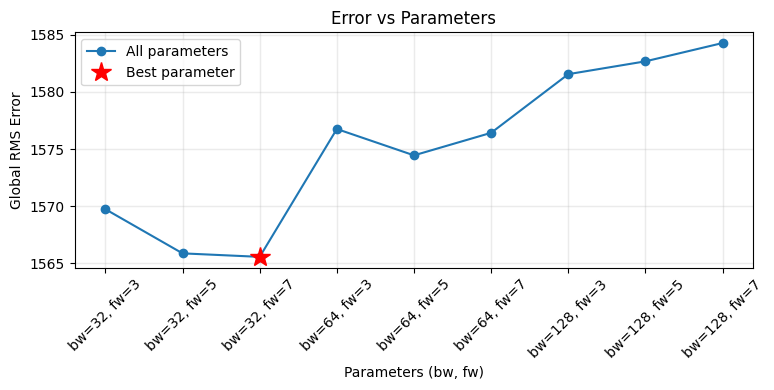

Processing file: /home/izm-ildana/astro/variable_search/data/masked_fits_file.fits


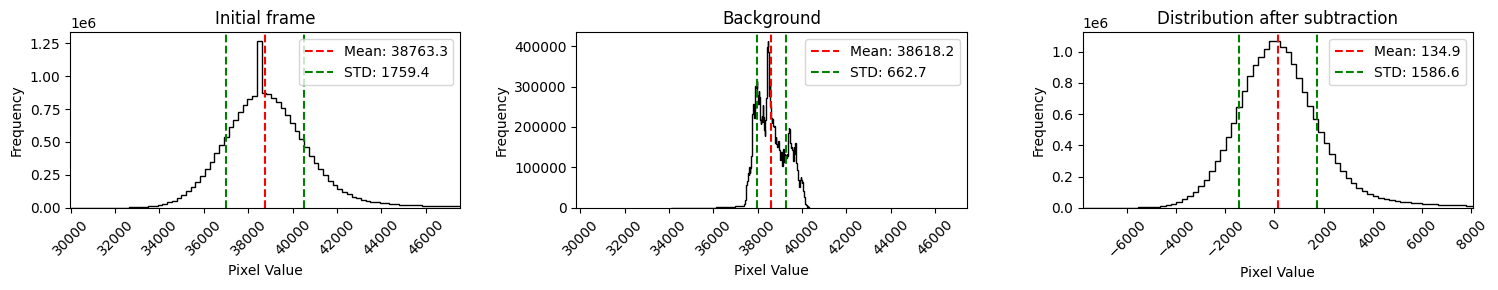

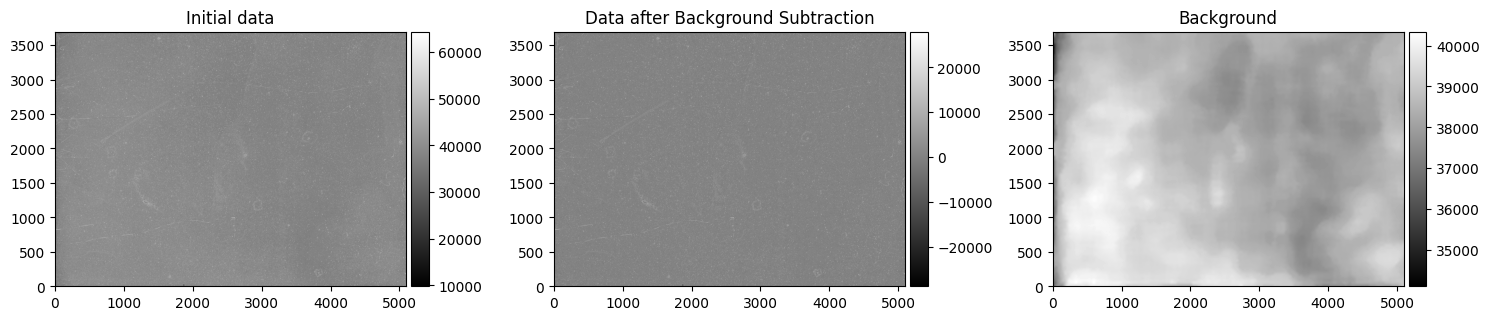

1526 objects found in /home/izm-ildana/astro/variable_search/data/masked_fits_file.fits


/tmp/ipykernel_3973/1547432525.py:388: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux)
Processing files:  50%|█████████████▌             | 1/2 [00:25<00:25, 25.69s/it]

Processed masked_fits_file.fits (1/2) in 25.69 seconds.
-------------------------------------------


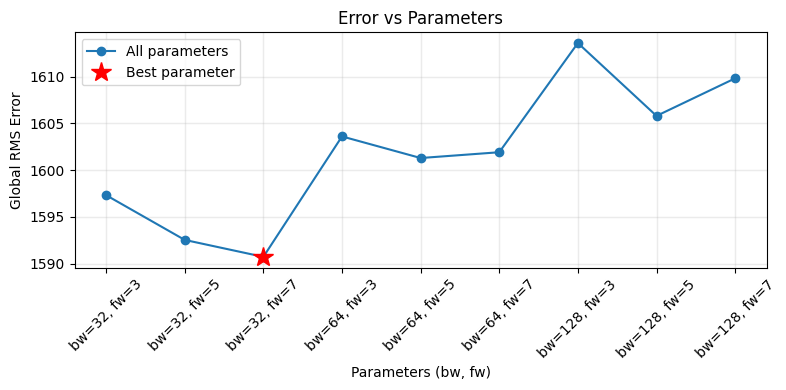

Processing file: /home/izm-ildana/astro/variable_search/data/alf-Cyg_20-21.10.1985_20m_77S-77986.fit


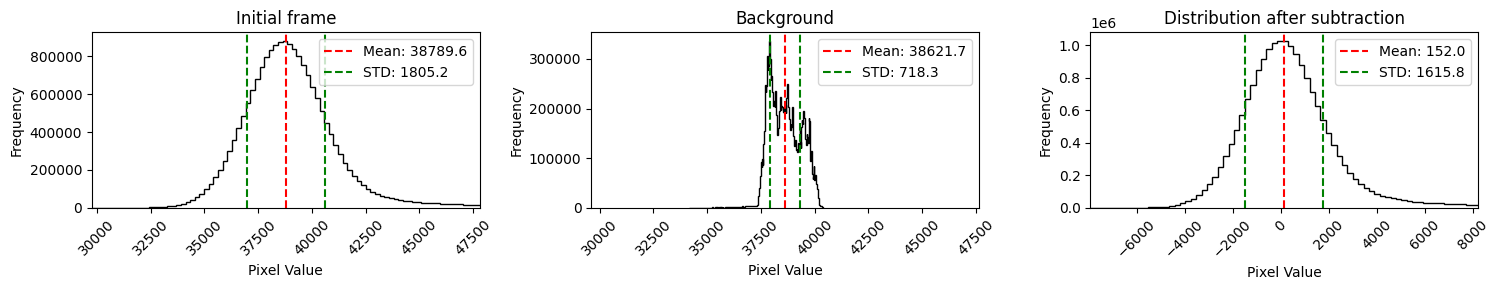

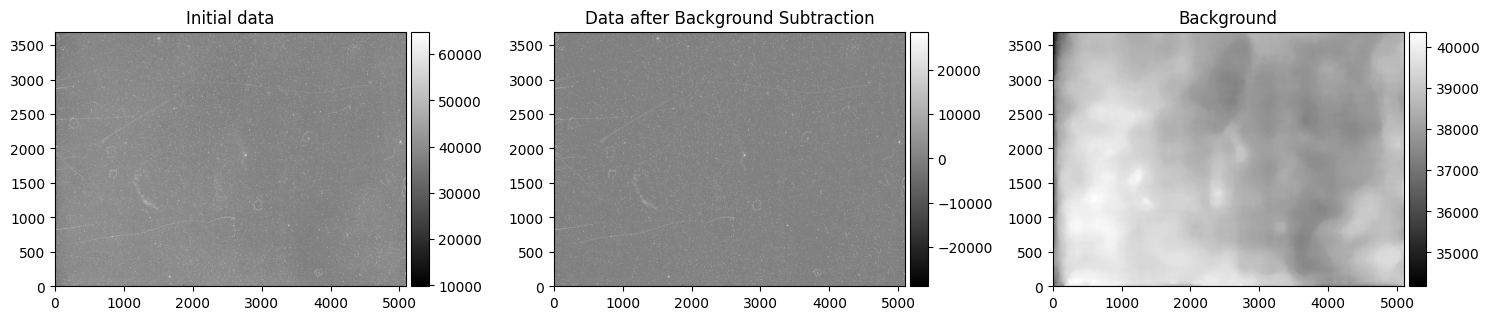

5319 objects found in /home/izm-ildana/astro/variable_search/data/alf-Cyg_20-21.10.1985_20m_77S-77986.fit


/tmp/ipykernel_3973/1547432525.py:388: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux)
Processing files: 100%|███████████████████████████| 2/2 [01:01<00:00, 30.92s/it]

Processed alf-Cyg_20-21.10.1985_20m_77S-77986.fit (2/2) in 36.14 seconds.
-------------------------------------------


In [14]:
process_directory(fits_directory, output_directory,scale='zscale')

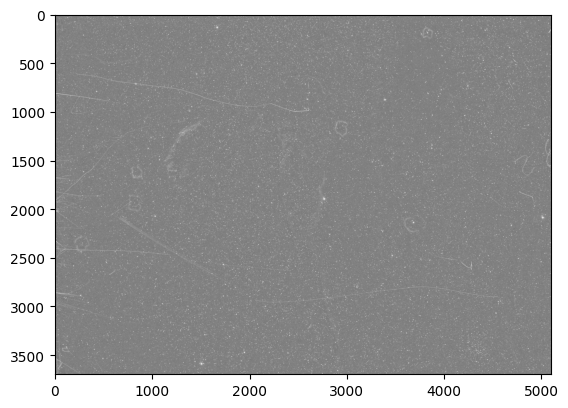

In [32]:
plt.imshow(data_subtr,cmap="gray")

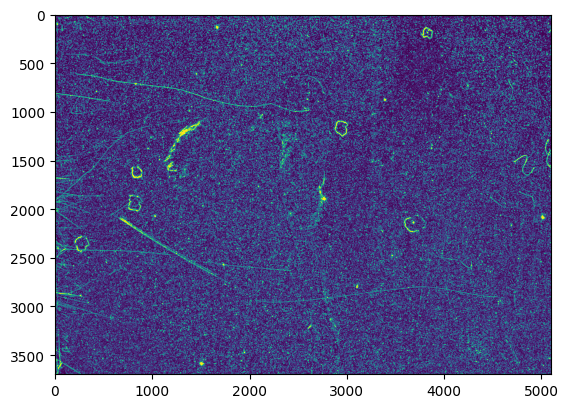

In [74]:
data_subtr_mask = np.where(data_subtr < np.mean(data_subtr)*3,0,1).astype(np.uint8)

plt.imshow(data_subtr_mask)

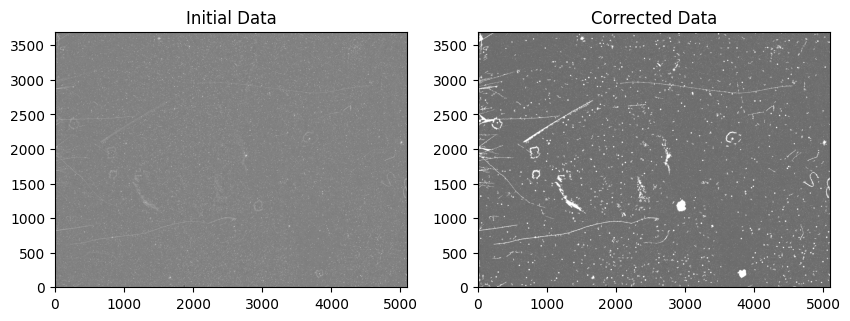

In [75]:

# Находим контуры на маске
contours, _ = cv2.findContours(data_subtr_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Создаем копию данных для замены артефактов
data_corrected = data_subtr.copy()

# Заменяем найденные артефакты на медианное значение фона
for contour in tqdm(contours, desc="Processing contours", unit="contour"):  # Добавляем прогресс-бар
    # Вычисляем контурную площадь и периметр
    area = cv2.contourArea(contour)
    perimeter = cv2.arcLength(contour, True)
    
    if area < 100:  # Порог для игнорирования маленьких шумов
        continue
    
    # Вычисляем соотношение площади к периметру
    if perimeter != 0:
        circularity = 4 * np.pi * (area / (perimeter ** 2))
    else:
        circularity = 1  # Для исключения деления на ноль
    
    # Если форма узкая и длинная (низкая "циркулярность"), это вероятно царапина или линия
    if circularity < 0.2:  # Порог для линейных объектов, можно варьировать
        cv2.drawContours(data_corrected, [contour], -1, np.median(bkg.back()), thickness=cv2.FILLED)

# Сохраняем исправленный файл (опционально)
# fits.writeto('corrected_fits_file.fits', data_corrected, overwrite=True)

# Визуализация результата
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(data_subtr, cmap='gray', origin='lower')
plt.title('Initial Data')

plt.subplot(1, 2, 2)
plt.imshow(data_corrected, cmap='gray', origin='lower')
plt.title('Corrected Data')

plt.show()

Processing contours: 100%|█████| 444891/444891 [00:00<00:00, 892118.70contour/s]


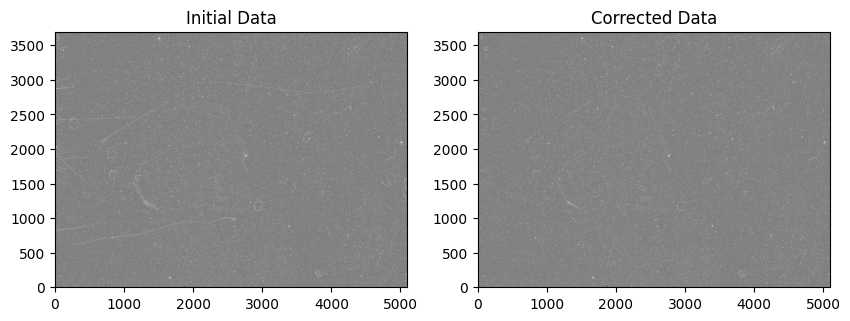

In [88]:

# Находим контуры на маске
contours, _ = cv2.findContours(data_subtr_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Создаем копию данных для замены артефактов
data_corrected = data_subtr.copy()

# Заменяем найденные артефакты на медианное значение фона
for contour in tqdm(contours, desc="Processing contours", unit="contour"):  # Добавляем прогресс-бар
    # Вычисляем контурную площадь и периметр
    area = cv2.contourArea(contour)
    perimeter = cv2.arcLength(contour, True)
    
    if area < 1500:  # Порог для игнорирования маленьких шумов
        continue
    
    # Вычисляем соотношение площади к периметру
    if perimeter != 0:
        circularity = 4 * np.pi * (area / (perimeter ** 2))
    else:
        circularity = 1  # Для исключения деления на ноль
    
    # Если форма узкая и длинная (низкая "циркулярность"), это вероятно царапина или линия
    if circularity < 0.2:  # Порог для линейных объектов, можно варьировать
        cv2.drawContours(data_corrected, [contour], -1,(255, 0, 255),thickness=5)#, thickness=cv2.FILLED)

# Сохраняем исправленный файл (опционально)
# fits.writeto('corrected_fits_file.fits', data_corrected, overwrite=True)

# Визуализация результата
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(data_subtr, cmap='gray', origin='lower')
plt.title('Initial Data')

plt.subplot(1, 2, 2)
plt.imshow(data_corrected, cmap='gray', origin='lower')
plt.title('Corrected Data')

plt.show()

# Scan error

In [28]:
# Загрузка данных из текстовых файлов и преобразование из градусов в арксекунды
ra_diff  = np.array(np.loadtxt("output/global_ra_diff.txt")) * 3600
dec_diff = np.array(np.loadtxt("output/global_dec_diff.txt")) * 3600

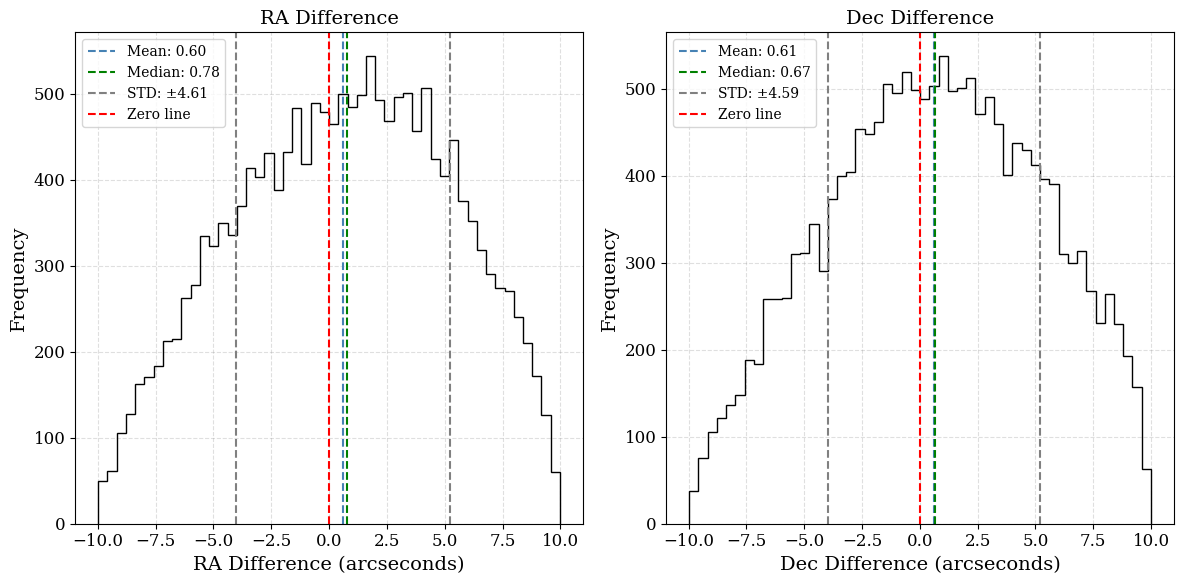

RA Difference (arcseconds) minimum  -9.9792
RA Difference (arcseconds) maximum  9.9792
DEC Difference (arcseconds) minimum  -9.9756
DEC Difference (arcseconds) maximum  9.993599999999999


In [29]:
# Создание фигуры с двумя сабплотами
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Гистограмма для разницы по RA
axs[0].hist(ra_diff, bins=50, color='blue', edgecolor='black', histtype='step')
mean_ra = np.mean(ra_diff)
std_ra = np.std(ra_diff)
median_ra = np.median(ra_diff)
axs[0].axvline(mean_ra, color='steelblue', linestyle='--', lw=1.5, label=f'Mean: {mean_ra:.2f}')
axs[0].axvline(median_ra, color='green', linestyle='--', lw=1.5, label=f'Median: {median_ra:.2f}')
axs[0].axvline(mean_ra + std_ra, color='gray', linestyle='--', lw=1.5, label=f'STD: ±{std_ra:.2f}')
axs[0].axvline(mean_ra - std_ra, color='gray', linestyle='--', lw=1.5)
axs[0].axvline(0, color='red', linestyle='--', lw=1.5, label='Zero line')
axs[0].set_title("RA Difference")
axs[0].set_xlabel("RA Difference (arcseconds)")
axs[0].set_ylabel("Frequency")
axs[0].grid(True)
axs[0].legend()

# Гистограмма для разницы по Dec
axs[1].hist(dec_diff, bins=50, color='green', edgecolor='black', histtype='step')
mean_dec = np.mean(dec_diff)
std_dec = np.std(dec_diff)
median_dec = np.median(dec_diff)
axs[1].axvline(mean_dec, color='steelblue', linestyle='--', lw=1.5, label=f'Mean: {mean_dec:.2f}')
axs[1].axvline(median_dec, color='green', linestyle='--', lw=1.5, label=f'Median: {median_dec:.2f}')
axs[1].axvline(mean_dec + std_dec, color='gray', linestyle='--', lw=1.5, label=f'STD: ±{std_dec:.2f}')
axs[1].axvline(mean_dec - std_dec, color='gray', linestyle='--', lw=1.5)
axs[1].axvline(0, color='red', linestyle='--', lw=1.5, label='Zero line')
axs[1].set_title("Dec Difference")
axs[1].set_xlabel("Dec Difference (arcseconds)")
axs[1].set_ylabel("Frequency")
axs[1].grid(True)
axs[1].legend()

# Настройка оформления и отображение
plt.tight_layout()
plt.show()

print("RA Difference (arcseconds) minimum ", np.min(ra_diff))
print("RA Difference (arcseconds) maximum ", np.max(ra_diff))
print("DEC Difference (arcseconds) minimum ", np.min(dec_diff))
print("DEC Difference (arcseconds) maximum ", np.max(dec_diff))